In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
# Initial imports
import numpy as np
import pandas as pd


# API import
import requests
import json

# Data cleaning
from datetime import datetime


# Plot import
%matplotlib inline


In [22]:
ticker = "ETH"
frequency = "1hour"
epoch = "1620360000"
response_data = requests.get(f'https://api.kucoin.com/api/v1/market/candles?type={frequency}&symbol={ticker}-USDT&startAt={epoch}&endAt=0&limit=10000').json()

data_price = pd.DataFrame(response_data['data'])
data_price[0] = pd.to_datetime(data_price[0], unit='s')
data_price.columns =['Hour', 'Opening_price',  'Closing_price' , 'Highest_price' , 'Lowest_price' , 'Transaction_volume' ,  'Transaction_amount']
data_price.sort_values(by=['Hour'], inplace=True)
data_price.set_index('Hour', inplace=True)
data_price = data_price.astype(float)
data_price.tail()

,Opening_price,Closing_price,Highest_price,Lowest_price,Transaction_volume,Transaction_amount
Hour,,,,,,
2022-01-20 20:00:00,3215.74,3195.28,3219.04,3184.00,3806.383624,1.217706e+07
2022-01-20 21:00:00,3195.29,3080.74,3197.26,3080.04,8957.291509,2.806991e+07
2022-01-20 22:00:00,3080.77,3061.41,3106.49,3022.74,8042.983697,2.470389e+07
2022-01-20 23:00:00,3061.41,3000.95,3061.81,2986.97,8846.349723,2.669846e+07
2022-01-21 00:00:00,3000.41,3028.44,3037.11,2972.19,7630.620051,2.290540e+07


In [41]:
data_price.index.max()


Timestamp('2022-01-21 00:00:00')

In [26]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Closing_price" price into two separate series:
Data_noise, Data_trend = sm.tsa.filters.hpfilter(data_price["Closing_price"])

In [27]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
Decomp_data = pd.DataFrame(data_price["Closing_price"])
Decomp_data['Noise'] = Data_noise
Decomp_data['Trend'] = Data_trend
Decomp_data.head()


,Closing_price,Noise,Trend
Hour,,,
2021-11-19 13:00:00,4206.44,-28.741670,4235.181670
2021-11-19 14:00:00,4232.98,-6.746140,4239.726140
2021-11-19 15:00:00,4216.79,-27.462647,4244.252647
2021-11-19 16:00:00,4251.43,2.690990,4248.739010
2021-11-19 17:00:00,4255.39,2.244115,4253.145885


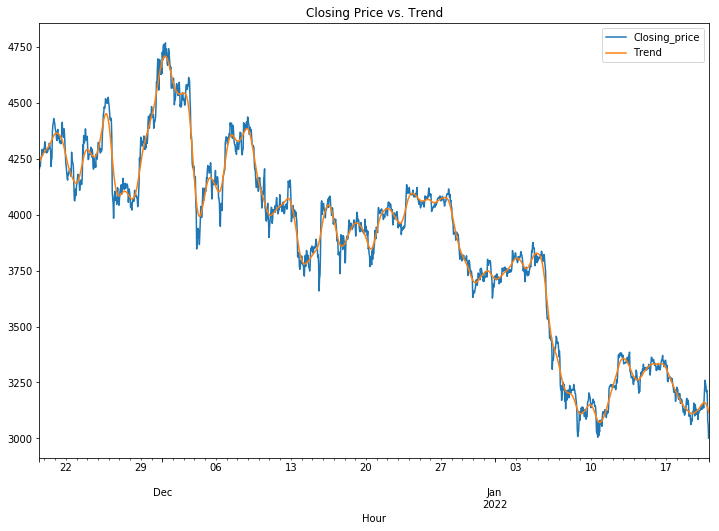

In [28]:
# # Plot the Settle Price vs. the Trend for 2015 to the present
Decomp_data[["Closing_price", "Trend"]]["2021-11-01":].plot(figsize=(12, 8), title="Closing Price vs. Trend")

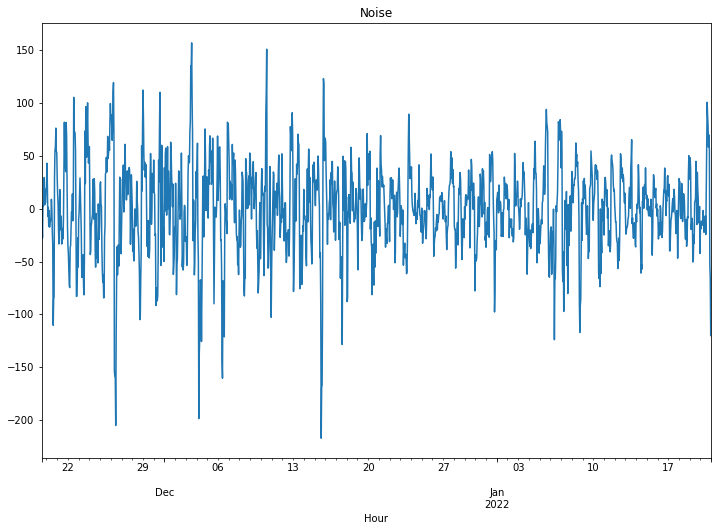

In [29]:
# Plot the Settle Noise
Data_noise.plot(figsize=(12, 8), title="Noise")

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

# Data Preparation

### Returns

In [30]:
data_price['Return'] = data_price.Closing_price.pct_change() * 100
data_price

,Opening_price,Closing_price,Highest_price,Lowest_price,Transaction_volume,Transaction_amount,Return
Hour,,,,,,,
2021-11-19 13:00:00,4141.31,4206.44,4209.11,4131.60,4052.052134,1.692205e+07,NaN
2021-11-19 14:00:00,4206.43,4232.98,4239.15,4188.45,3594.458633,1.514779e+07,0.630937
2021-11-19 15:00:00,4233.96,4216.79,4237.15,4206.91,2620.933387,1.106367e+07,-0.382473
2021-11-19 16:00:00,4216.79,4251.43,4255.90,4210.11,2283.032499,9.654136e+06,0.821478
2021-11-19 17:00:00,4251.43,4255.39,4277.86,4250.06,2418.567154,1.031561e+07,0.093145
...,...,...,...,...,...,...,...
2022-01-20 20:00:00,3215.74,3195.28,3219.04,3184.00,3806.383624,1.217706e+07,-0.636245
2022-01-20 21:00:00,3195.29,3080.74,3197.26,3080.04,8957.291509,2.806991e+07,-3.584662
2022-01-20 22:00:00,3080.77,3061.41,3106.49,3022.74,8042.983697,2.470389e+07,-0.627447


In [31]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
data_price['Return'] = data_price.Closing_price.pct_change() * 100

# In this case, you may have to replace inf, -inf values with np.nan"s
data_price = data_price.replace(-np.inf, np.nan).dropna()
data_price = data_price.replace(np.inf, np.nan).dropna()
data_price = data_price.dropna()
data_price.head()

,Opening_price,Closing_price,Highest_price,Lowest_price,Transaction_volume,Transaction_amount,Return
Hour,,,,,,,
2021-11-19 14:00:00,4206.43,4232.98,4239.15,4188.45,3594.458633,1.514779e+07,0.630937
2021-11-19 15:00:00,4233.96,4216.79,4237.15,4206.91,2620.933387,1.106367e+07,-0.382473
2021-11-19 16:00:00,4216.79,4251.43,4255.90,4210.11,2283.032499,9.654136e+06,0.821478
2021-11-19 17:00:00,4251.43,4255.39,4277.86,4250.06,2418.567154,1.031561e+07,0.093145
2021-11-19 18:00:00,4254.88,4266.18,4266.99,4243.48,1863.737369,7.932873e+06,0.253561


### Lagged Returns 

In [32]:
# Create a lagged return using the shift function
data_price['Lagged_Return'] = data_price.Return.shift()
data_price = data_price.replace(-np.inf, np.nan).dropna()
data_price = data_price.replace(np.inf, np.nan).dropna()
data_price = data_price.dropna()
data_price.head()

,Opening_price,Closing_price,Highest_price,Lowest_price,Transaction_volume,Transaction_amount,Return,Lagged_Return
Hour,,,,,,,,
2021-11-19 15:00:00,4233.96,4216.79,4237.15,4206.91,2620.933387,1.106367e+07,-0.382473,0.630937
2021-11-19 16:00:00,4216.79,4251.43,4255.90,4210.11,2283.032499,9.654136e+06,0.821478,-0.382473
2021-11-19 17:00:00,4251.43,4255.39,4277.86,4250.06,2418.567154,1.031561e+07,0.093145,0.821478
2021-11-19 18:00:00,4254.88,4266.18,4266.99,4243.48,1863.737369,7.932873e+06,0.253561,0.093145
2021-11-19 19:00:00,4266.19,4291.16,4298.20,4254.75,2148.751506,9.182966e+06,0.585536,0.253561


### Train Test Split

In [42]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = data_price[:'2022-1-10']
test = data_price['2022-1-10':]

In [43]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [44]:
X_train

,Lagged_Return
Hour,
2021-11-19 15:00:00,0.630937
2021-11-19 16:00:00,-0.382473
2021-11-19 17:00:00,0.821478
2021-11-19 18:00:00,0.093145
2021-11-19 19:00:00,0.253561
...,...
2022-01-10 19:00:00,1.044146
2022-01-10 20:00:00,-0.453100
2022-01-10 21:00:00,1.686641


# Linear Regression Model

In [45]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)
LinearRegression()

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [46]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [47]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x148d47890>,
      dtype=object)

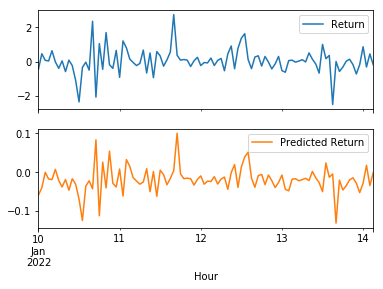

In [48]:
# Plot the first 20 predictions vs the true values
Results[:100].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [49]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.7153676223327111


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [50]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.817744659256487
